In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import scipy as sc

### 1. вывести все типы событий, подсчитать количество их вхождений и сохранить в файл types.json

In [2]:
#Считываем данные

data = pd.read_json(r'D:\HPDemo\Data for projects\GOSU.AI\test-task_020922018\3549145408_1618162017.jsonl', lines=True)

In [3]:
# Выводим и считаем типы событий. Записываем в types.json

types_counts = data['type'].value_counts()
types_counts.to_json(path_or_buf=r'D:\HPDemo\Projects\GOSU.AI\gosu-test\documents_to_send\types.json',
                     orient='index')

### 2. Для каждого игрока необходимо нарисовать heatmap положений его курсора в течение всего матча 

In [4]:
def player_activity_hexbin(
    data: pd.DataFrame, y: str, x: str, slot: list
    ):
    """
    Plotting player's mouse activity during the match.
    
    :param data:
        game stats in 
        column a pd.DataFrame format
    :param y:
        column name of player's mouse position on y-axis
    :param x:name of player's mouse position on x-axis
    :param slot:
        list of active slots 
    :return:
        Create a heatmap_<slot>.png in a working directory
    """
    for i in slot:
        player = data[(data['type'] == 'cursor') & (data['slot'] == i)]
        plt.figure(figsize=(10, 7.5))
        plt.hexbin(player[y], player[x], vmax=275, gridsize=30, cmap='jet')
        plt.gca().invert_xaxis()
        plt.axis([player[y].max(), 0, 0, player[x].max()])
        plt.colorbar().set_label('mean value')
        plt.savefig('heatmap_%s.png' % i)
        plt.show()

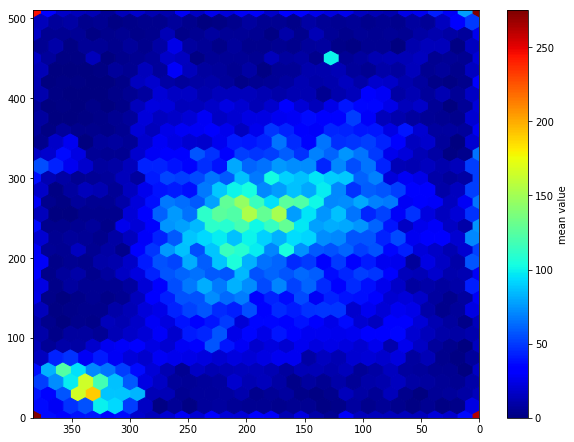

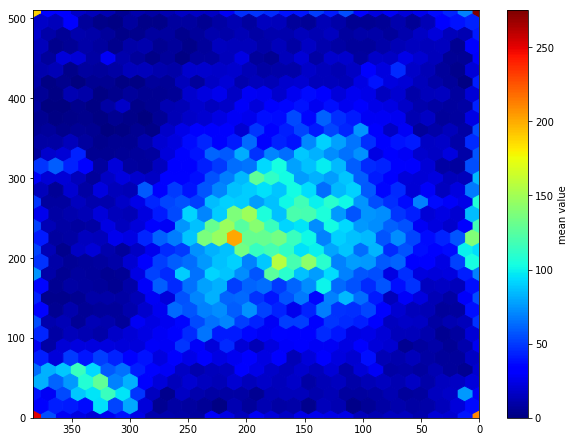

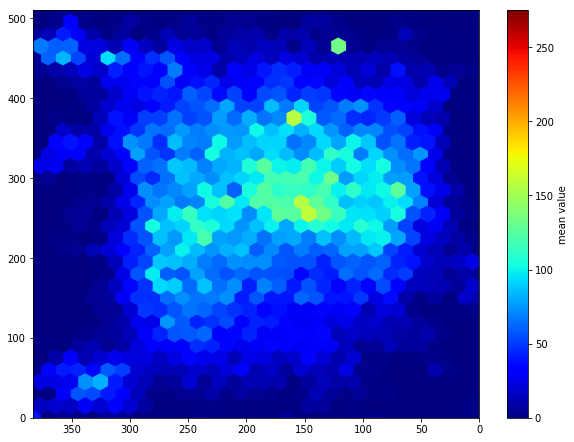

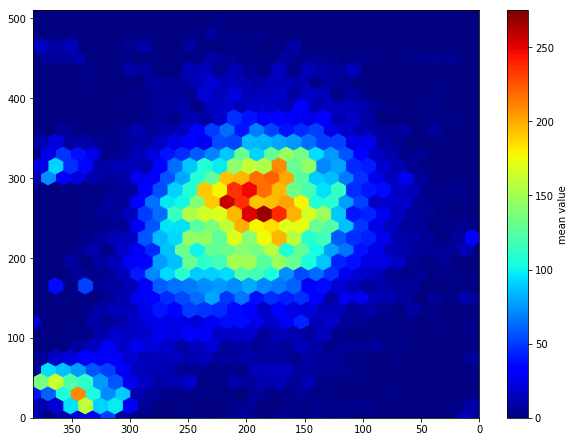

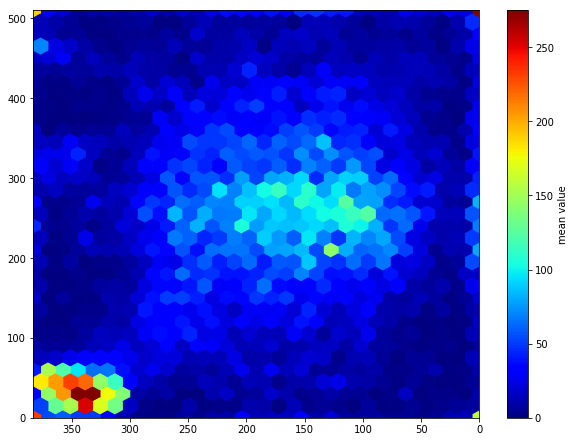

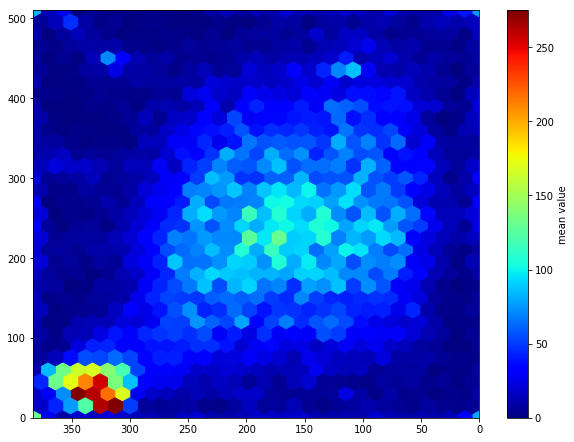

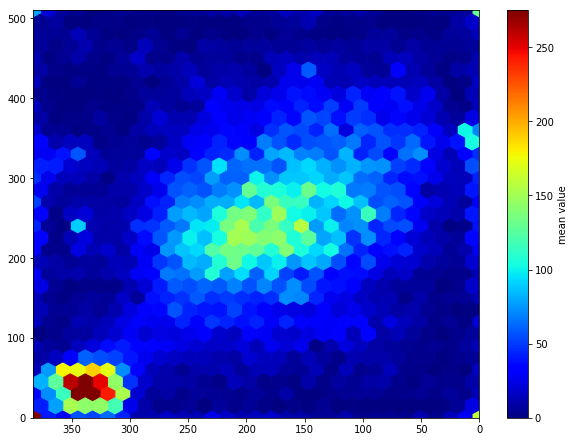

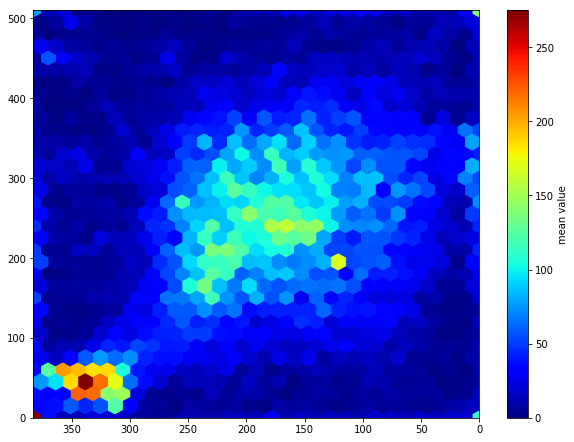

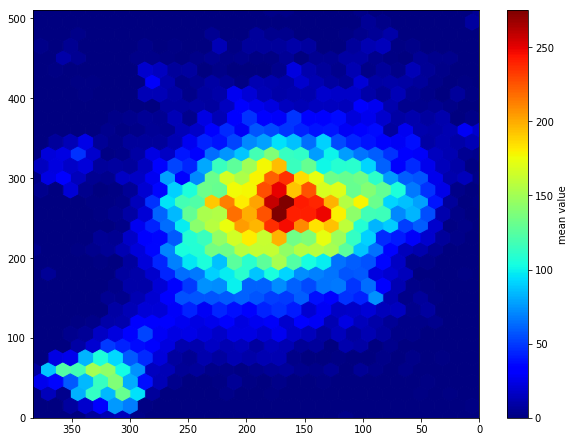

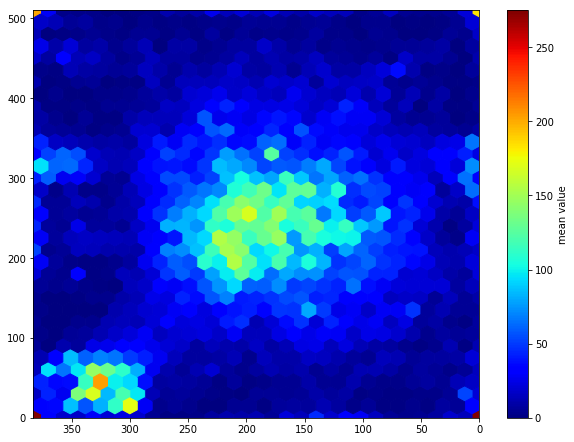

In [5]:
player_activity_hexbin(data, 'y', 'x', [x for x in range(10)])

### 3. Статистический тест покупки предмета в разных патчах

In [27]:
import requests
import json
import urllib
import scipy as sc

In [9]:
# Данный запрос был сформирован на основе https://www.opendota.com/explorer
# Мы выбираем 1000 первых матчей в патче 7.07
# Делаем percentage encoding

data_sql_707 = urllib.parse.quote('SELECT\n'
                              'matches.match_id,\n' 
                              'matches.start_time,\n'
                              'player_matches.hero_id,\n'
                              'player_matches.purchase_log\n'
                              'FROM matches\n'
                              'JOIN match_patch using(match_id)\n'
                              'JOIN player_matches using(match_id)\n'
                              'WHERE TRUE\n'
                              'AND match_patch.patch >= \'7.07\'\n'
                              'AND match_patch.patch <= \'7.07\'\n'
                              'ORDER BY matches.start_time ASC\n'
                              'LIMIT 10000', safe='()')

url_707 = 'https://api.opendota.com/api/explorer?sql=' + data_sql_707

In [16]:
# Делаем запрос

req_707 = requests.get(url_707)
req_707 = json.loads(req_707.text)

In [18]:
# У нас 10000 записей, по 10 на матч
# Для каждой записи, смотрим, является ли персонаж 'anti-mage'
# Если да, то смотрим знаения приобретения 'bfury'

bf_timing_707 = []
for i in req_707['rows']:
    if i['purchase_log'] is not None:
        for y in i['purchase_log']:
            if (y['key'] == 'bfury') and (i['hero_id'] == 1):
                bf_timing_707.append(y['time'])

In [19]:
# Аналогичная процедура для сбора информации по патчу 7.06
# Собираем 1000 последний матчей

data_sql_706 = urllib.parse.quote('SELECT\n'
                              'matches.match_id,\n' 
                              'matches.start_time,\n'
                              'player_matches.hero_id,\n'
                              'player_matches.purchase_log\n'
                              'FROM matches\n'
                              'JOIN match_patch using(match_id)\n'
                              'JOIN player_matches using(match_id)\n'
                              'WHERE TRUE\n'
                              'AND match_patch.patch >= \'7.06\'\n'
                              'AND match_patch.patch <= \'7.06\'\n'
                              'ORDER BY matches.start_time DESC\n'
                              'LIMIT 10000', safe='()')

url_706 = 'https://api.opendota.com/api/explorer?sql=' + data_sql_706

In [20]:
# Делаем запрос 

req_706 = requests.get(url_706)
req_706 = json.loads(req_706.text)

In [23]:
# Аналогичная процедура

bf_timing_706 = []
for i in req_706['rows']:
    if i['purchase_log'] is not None:
        for y in i['purchase_log']:
            if (y['key'] == 'bfury') and (i['hero_id'] == 1):
                bf_timing_706.append(y['time'])

D:\Anaconda\envs\classic\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


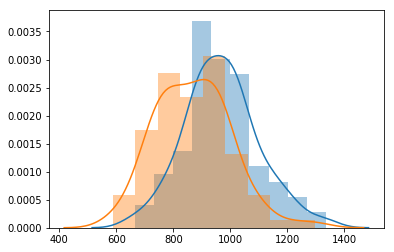

In [24]:
# Сдалем график с распределением времени покупки
# Визуально, патч оказал серьезное влияние на тайминг 'bfury'

sns.distplot(bf_timing_706)
sns.distplot(bf_timing_707)
plt.show()

In [28]:
# Проведем тест, отличаються ли средние двух распределений
# для этого будем использовать тест из библиотеки scipy

def two_means_are_diff(
    data_707: list, data_706: list, alpha: int
    ):
    '''
    Conduct a two-sided test for the null hypothesis 
    that two independed samples have identical expected values.
    Assumed that there is no difference in sample variances 
    (can be checked via Bartlett's test)
    and samples are normally disributed 
    (can be checked via normaltest in scipy)
    
    :param data_707:
        time sample of bf purchase for am in 7.07 patch   
    :param data_706:
        time sample of bf purchase for am in 7.06 patch
    :alpha:
        significance level (threshold for p-value)
    '''
    
    t, p_value = sc.stats.ttest_ind(data_707, data_706)
    if p_value <= alpha:
        print('Null hypothesis is rejected, means of bf purchase are different')
    else:
        print('Null hypothesis is consistent, means of bf purchase are the same')

In [29]:
two_means_are_diff(bf_timing_706, bf_timing_707, 0.05)

Null hypothesis is rejected, means of bf purchase are different


### 4. Линейная регрессия общей стоимости персонажа

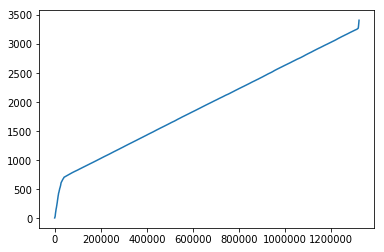

In [30]:
plt.plot(data['time'])
plt.show()

# похоже, что в time включены блоки, предшествующие матчу, например драфт
# task_one: определить корректное время начала и окончания для построения регрессии

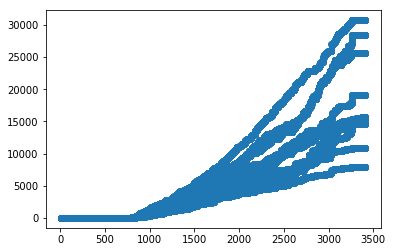

In [31]:
# Начальный уровень gold равен = 0. Как только начинается матч, идёт прибавка ~ 1-2 монеты в секунду 
# Однако нужно еще учесть тот факт, что существует 90 секунд до начала матча,
# когда игроки могут совершать убийства и это будет влиять на их ценность

plt.scatter(y=data['gold'], x=data['time'])

# также 'gold' Не меняется в конце, то есть попадает отрезок, когда игроки, например
# просматривают статистику игры. Необходимо отсечь данный отрезок.
# Будем использовать эвритсику: если 'gold' героя не меняется 2 раза подряд, значит наступил конец матча

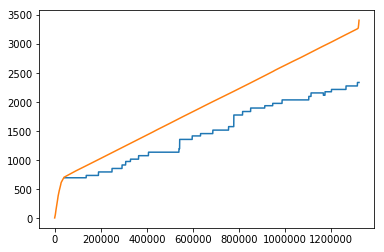

In [32]:
# Одним из показателей начала матча (появление игроков на поле) может служить здоровье персонажа
# Построим график, показывающий зависимость времени и здоровья персонажа

plt.plot(data[(data['type'] == 'interval') & (data['slot'] == 1)]['max_health'])
plt.plot(data[(data['type'] == 'interval') & (data['slot'] == 1)]['time'])
plt.show()

# Будем использовать 'max_health' как индикатор появления игроков

In [33]:
# Формируем вспомогательный df

data_for_time = data[(data['type'] == 'interval')][['max_health', 'time', 'gold']]

# определяем время старта матча, 'max_health' > 0

for i in range(len(data_for_time)):
    if pd.isnull(data_for_time.iloc[i][0]):
        continue
    else:
        start = data_for_time.iloc[i][1]
        break

# Также было отмечено, что есть отрезок в конце, когда матч завершен
# И gold перестает расти - необходимо отсечь этот период,
# То есть определить время окончания матча
        
data_for_time = data_for_time[data_for_time['gold'] > 1]

for i in range(len(data_for_time)):
    if (data_for_time.iloc[i][2] == data_for_time.iloc[i+20][2]):
        end = data_for_time.iloc[i][1]
        break
    else:
        continue
        
print('время старта %s и окончания %s для построения регрессии' % (start, end))

# время старта 709.84827, однако gold начинает расти с 799.89294
# Это объясняется тем, что у игроков есть 90 секунд на подготовку
# В это время деньги не начисляются, однаком может быть соверешенно убйиство,
# которое повлияет на уровень золота игрока

время старта 709.84827 и окончания 3265.3682 для построения регрессии


#### Нужно ли использовать intercept?

Нет, так как пероснажи начинают с показателем 'gold' = 0.
Добавление Intercept было бы необходимо если бы у игроков была бы возможность
заработать 'gold' до появления на поле. Например гипотетический премиум аккаунт,
который дает +1000 'gold' или выбор определенного персонажа мог дать дополнительный бонус
к золоту до появления на поля (до фактического старта матча).

In [34]:
# Импортируем модуль линейной регрессии

from sklearn.linear_model import LinearRegression

# существует также реализация регрессии в scipy, которая также рассчитывает p-value
# Однако там нельзя отключить intercept, в то время как в модуле от sklearn - можно
# Будет строить тест о занчимости коэффициентов регрессии самостоятельно

In [35]:
# отключаем interceptor

clf = LinearRegression(fit_intercept=False)

In [36]:
def regression_coefficient_significanse(
    player: int, alpha: int
    ):
    '''
    Test whether regression coefficient is significant
    
    :param player:
        slot number of player (from 0 to 9 inclusive)
    :param alpha:
        significance level 
    '''
    player_data = data[(data['type'] == 'interval') &
                       (data['slot'] == player) &
                       (data['time'] >= start) &
                       (data['time'] <= end)][['time', 'gold']]

    X = player_data['time'].values.reshape(-1, 1) - start
    y = player_data['gold'].values.reshape(-1, 1)
    clf.fit(X, y)
    
    # degrees of freedom
    degrees_of_freedom = len(X) - 2 
    
    # find std for the slope
    A = np.sqrt(np.sum(np.power(y - clf.predict(X), 2))/degrees_of_freedom)
    B = np.sqrt(np.sum(np.power(X - np.mean(X), 2)))
    std_of_the_slope = A/B
   
    # t-stat
    T_stat = clf.coef_ / std_of_the_slope

    # p-value associated with t-stat
    p_value = 2 * sc.stats.t.sf(np.abs(T_stat), degrees_of_freedom) 
    if p_value <= alpha:
        print('Null hypothesis is rejected. Regression coefficient for player %s ' 
              'is significant. There is linear relationship between 2 variables' % player)
    else:
        print('Null hypothesis is accepted. There is no difference'
              'between 0 and slope coefficient for player %s' % player)

#### Значимы ли коэффициенты регрессии?

In [37]:
for i in range(10):
    regression_coefficient_significanse(i, 0.05)

Null hypothesis is rejected. Regression coefficient for player 0 is significant. There is linear relationship between 2 variables
Null hypothesis is rejected. Regression coefficient for player 1 is significant. There is linear relationship between 2 variables
Null hypothesis is rejected. Regression coefficient for player 2 is significant. There is linear relationship between 2 variables
Null hypothesis is rejected. Regression coefficient for player 3 is significant. There is linear relationship between 2 variables
Null hypothesis is rejected. Regression coefficient for player 4 is significant. There is linear relationship between 2 variables
Null hypothesis is rejected. Regression coefficient for player 5 is significant. There is linear relationship between 2 variables
Null hypothesis is rejected. Regression coefficient for player 6 is significant. There is linear relationship between 2 variables
Null hypothesis is rejected. Regression coefficient for player 7 is significant. There is 

#### Какой смысл в терминах игры имеет коэффициент наклона?

Коэффциент наклона показывает скорость роста ценности персонажа с течением времени матча. Чем круче наклон, тем больше золота получает персонаж с каждой новой секундой проведенной в матче.

### 5. Определение количества и длительности нападения

In [38]:
# Сформируем датасеты для определения длительности нападения и нападавших

data_death = data[(data['type'] == 'DOTA_COMBATLOG_DEATH')].dropna(axis=1)

data_damage = data[(data['type'] == 'DOTA_COMBATLOG_DAMAGE')].dropna(axis=1)

In [39]:
# создаем список героев, участвующих в матче
heroes = [x for x in set(data_death[data_death['attackerhero'] == 1.0]['attackername'])]
kills = []
for hero in heroes:
    time_deaths = data_death[data_death['targetname'] == hero]['time'].values.reshape(-1, 1)
    
# Для каждой смерти ('end_time') персонада будем искать время старта и нападавших  
    for death in time_deaths:
        example = {}
        
# время окончания нападения мы знаем, надо найти время старта      
        end = float(death)
        time_fight = data_damage[(data_damage['targetname'] == hero) & 
                                 (data_damage['time'] < end)]['time'].values.reshape(-1, 1)
        
# Наша эвристика: максимальное количество секунд между ударами персоанажа,
# которые будут учитываться равно 6
# Соответственно, как только находятся удары, разницы между котороыми во времени составляет
# более 6 сек, время последнего удара является временем начала нападения

        for i in range(len(time_fight)):
            if time_fight[::-1][i] - time_fight[::-1][i+1] < 6:
                start = time_fight[::-1][i+1]
            else:
                start = time_fight[::-1][i]
                break

# Составим множесто всех нападавших между временем старта и окончания нападения
        hero_killers = data_damage[(data_damage['attackerhero'] == 1.0) &
                                   (data_damage['time'] > float(start)) & 
                                   (data_damage['time'] < float(end)) &
                                   (data_damage['targetname'] == hero)]['attackername']

        example['targethero'] = hero
        example['start_time'] = float(start) 
        example['end_time'] = end
        hero_killers = set(hero_killers)

# Некоторые спосбности персонажей (1-ый скилл TB) будем отражать, 
# что персонаж атакован самим собой. Исключим этот вариант
        hero_killers.discard(hero)
        if hero_killers == False:
            hero_killers = {}
        example['kill_participants'] = list(hero_killers)
        kills.append(example)
kills = pd.DataFrame(kills)
kills = kills[['targethero', 'start_time', 'end_time', 'kill_participants']]

In [61]:
# Записываем в файл

kills.to_json(path_or_buf=r'D:\HPDemo\Projects\GOSU.AI\gosu-test\documents_to_send\kills.json', 
              orient='records')